# Projet de Simulation et Monte Carlo  
  
  Ce projet se base sur l'arcticle de Yuyang Shi et Rob Cornish : On Multilevel Monte Carlo Unbiased Gradient Estimation For Deep Latent Variable Models (2021) http://proceedings.mlr.press/v130/shi21d.html

In [51]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import random

## Partie 1 : Génération des données 
Comme dit dans l'article, nous étudions les modèles à variables latentes. pour pouvoir générer les données, nous considérerons une expérience gaussienne linéaire de la même manière que Rainforth et al. (2018) et Tucker et al. (2019)  

   On considère le modèle génératif suivant : $p_{\theta}(x,z)= \mathcal{N}(z|\theta,I)\mathcal{N}(x|z,I)$ où $x,z \in \mathbb{R^{20}}$ tel que $p_{\theta}(x)= \mathcal{N}(x|\theta,2I)$ et $p_{\theta}(z|x)= \mathcal{N}(\frac{\theta+x}{2},\frac{1}{2}I)$. La distribution de l'encodeur est $q_{\phi}(z|x)=\mathcal{N}(z|Ax+b,\frac{2}{3}I)$, où $\phi = (A,b)$. On considère une perturbation aléatoire des paramètres autour de la valeur optimale par une gaussienne centré de variance 0.01.
    

In [52]:
theta = np.random.normal(0, 1)
theta_vector = np.full(20, theta)
r = 0.6
A_true = (1/2)*np.eye(20)
b_true = theta_vector/2
X_data = multivariate_normal.rvs(theta_vector, 2*np.eye(20))
start = -4
end = 4
step = 0.05
mu_list = np.arange(start+theta, end+theta, step)
N = 10
N_bias = 300
K_iwae = 5
print('theta = ' + str(theta))

theta = 0.7626795177330455


In [53]:
def parameter_perturbation(A, b):
    return A+np.eye(20)*np.random.normal(0, 0.01), b+np.random.normal(0, 0.01)

In [54]:
def generate_z(K, A, b, x):
    mean_z = np.dot(A, x)+b
    return np.random.multivariate_normal(mean_z, (2/3)*np.eye(20), size = 2**(K+1))

In [55]:
def q_phi(z, A, b, x):
    mean_z = np.dot(A, x)+b
    return multivariate_normal(mean_z, (2/3)*np.eye(20)).pdf(z)

In [56]:
def p_joint(z, K, x, mu):
    p = []
    mu_vector = np.full(20, mu)
    for i in range(2**(K+1)):
        p.append(multivariate_normal.pdf(z[i], mu_vector, np.eye(20))*multivariate_normal.pdf(x,z[i],np.eye(20)))
    return np.array(p)

## Partie 2 : Estimation de la vraisemblance  
  
  Dans cette partie, nous allons reproduire les estimateurs SS, RR, IWAE et SUMO cités dans l'article

### A - Log-Vraisemblance théorique de $p_{\theta}(x)$

In [57]:
def log_likelihood(x,mu):
    mu_vector = np.full(20, mu)
    return -10*np.log(2*np.pi)-10*np.log(2)-0.25*np.dot(x-mu_vector,x-mu_vector)

In [58]:
def list_log_likelihood(x):
    list_log_likelihood_mu = []
    for mu in mu_list:
        list_log_likelihood_mu.append(log_likelihood(x, mu))
    return list_log_likelihood_mu

In [59]:
list_log_likelihood_mu = list_log_likelihood(X_data)

### B - Estimateur SS :

  #### B.1 - Création de l'estimateur

In [60]:
def SS_estimator(A, b, x, mu, N_sim):
    list_ss = []
    for i in range(N_sim):
        K = np.random.geometric(r)
        Z_data = generate_z(K, A, b, x)
        q = q_phi(Z_data, A, b, x)
        p = p_joint(Z_data, K, x, mu)
        log_w = np.log(p) - np.log(q)
        log_w_O = log_w[1::2]
        log_w_E = log_w[::2]
        I0 = log_w.mean()
        l_O = logsumexp(log_w_O) - np.log(len(log_w_O))
        l_E = logsumexp(log_w_E) - np.log(len(log_w_E))
        l_OUE = logsumexp(log_w) - np.log(len(log_w))
        delta_K = l_OUE - 0.5*(l_O + l_E)
        SS = I0 + (delta_K/(r*(1-r)**(K-1)))
        list_ss.append(SS)
    return np.mean(list_ss)

#### B.2 - Visualisation SS

In [61]:
def visualisation_SS(A, b, x, N_sim):
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    list_ss_mu = []
    for mu in mu_list:
        list_ss_mu_10 = []
        for i in range(10):
            ss_estimator = SS_estimator(A_perturbed, b_perturbed, x, mu, N_sim)
            list_ss_mu_10.append(ss_estimator)
        mean_ss = np.mean(list_ss_mu_10)
        list_ss_mu.append(mean_ss)
    return list_ss_mu

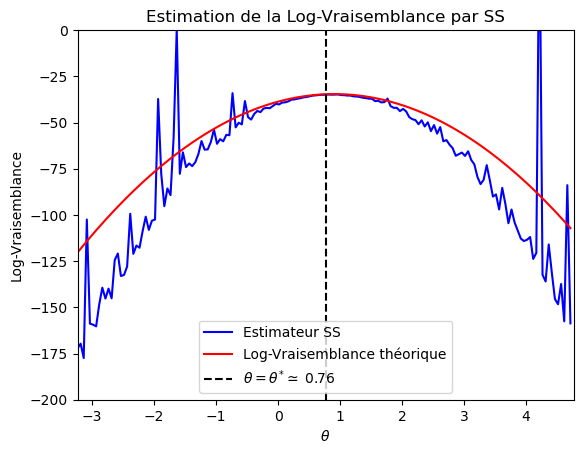

In [62]:
list_ss_mu = visualisation_SS(A_true, b_true, X_data, N)

plt.clf()
plt.plot(mu_list, list_ss_mu, color='blue', label='Estimateur SS')
plt.plot(mu_list, list_log_likelihood_mu, color='red', label='Log-Vraisemblance théorique')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel('Log-Vraisemblance')
plt.ylim(-200,0)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation de la Log-Vraisemblance par SS')
plt.show()

### C - Estimateur RR

#### C.1 - Création de l'estimateur

In [63]:
def RR_estimator(A, b, x, mu, N_sim):
    list_rr = []
    for i in range(N_sim):
        K = np.random.geometric(r)
        Z_data = generate_z(K, A, b, x)
        q = q_phi(Z_data, A, b, x)
        p = p_joint(Z_data, K, x, mu)
        log_w = np.log(p) - np.log(q)
        log_w_O = log_w[1::2]
        log_w_E = log_w[::2]
        I0 = log_w.mean()
        RR = I0
        for l in range(K+1):
            l_O = logsumexp(log_w_O[:2**l]) - np.log(len(log_w_O[:2**l]))
            l_E = logsumexp(log_w_E[:2**l]) - np.log(len(log_w_E[:2**l]))
            l_OUE = logsumexp(log_w[:2**(l+1)]) - np.log(len(log_w[:2**(l+1)]))
            delta_l = l_OUE - 0.5*(l_O + l_E)
            RR += delta_l/((1-r)**max(l-1,0))
        list_rr.append(RR)
    return np.mean(list_rr)

#### C.2 - Visualisation RR

In [64]:
def visualisation_RR(A, b, x, N_sim):
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    list_rr_mu = []
    for mu in mu_list:
        list_rr_mu_10 = []
        for i in range(10):
            rr_estimator = RR_estimator(A_perturbed, b_perturbed, x, mu, N_sim)
            list_rr_mu_10.append(rr_estimator)
        mean_rr = np.mean(list_rr_mu_10)
        list_rr_mu.append(mean_rr)
    return list_rr_mu

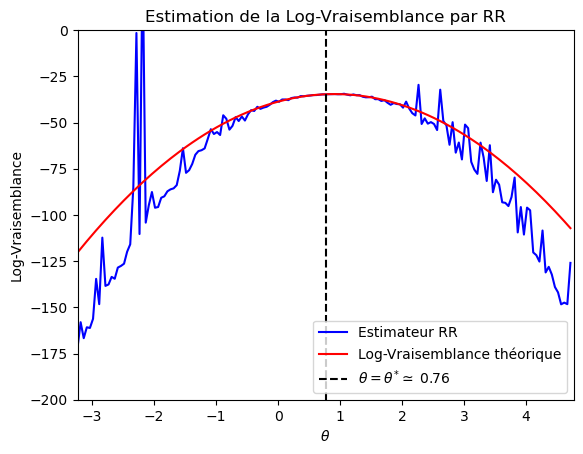

In [65]:
list_rr_mu = visualisation_RR(A_true, b_true, X_data, N)

plt.clf()
plt.plot(mu_list, list_rr_mu, color='blue', label='Estimateur RR')
plt.plot(mu_list, list_log_likelihood_mu, color='red', label='Log-Vraisemblance théorique')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel('Log-Vraisemblance')
plt.ylim(-200,0)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation de la Log-Vraisemblance par RR')
plt.show()

### D - Estimateur IWAE

#### D.1 - Création de l'estimateur

In [66]:
def generate_z_iwae(K, A, b, x):
    mean_z = np.dot(A, x)+b
    return np.random.multivariate_normal(mean_z, (2/3)*np.eye(20), size = K)

In [67]:
def p_joint_iwae(z, K, x, mu):
    p = []
    mu_vector = np.zeros(20)+mu
    for i in range(K):
        p.append(multivariate_normal.pdf(z[i], mu_vector, np.eye(20))*multivariate_normal.pdf(x,z[i],np.eye(20)))
    return np.array(p)

#### D.2 - Visualisation IWAE

In [68]:
def IWAE_estimator(A, b, x, mu, K, N_sim):
    list_IWAE = []
    for i in range(N_sim):
        Z_data = generate_z_iwae(K, A, b, x)
        q = q_phi(Z_data, A, b, x)
        p = p_joint_iwae(Z_data, K, x, mu)
        log_w = np.log(p) - np.log(q)
        IWAE = logsumexp(log_w) - np.log(len(log_w))
        list_IWAE.append(IWAE)
    return np.mean(IWAE)

In [69]:
def visualisation_IWAE(A, b, x, K, N_sim):
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    list_iwae_mu = []
    for mu in mu_list:
        list_iwae_mu_10 =[]
        for i in range(10):
            iwae_estimator = IWAE_estimator(A_perturbed, b_perturbed, x, mu, K, N_sim)
            list_iwae_mu_10.append(iwae_estimator)
        mean_iwae = np.mean(list_iwae_mu_10)
        list_iwae_mu.append(mean_iwae)
    return list_iwae_mu

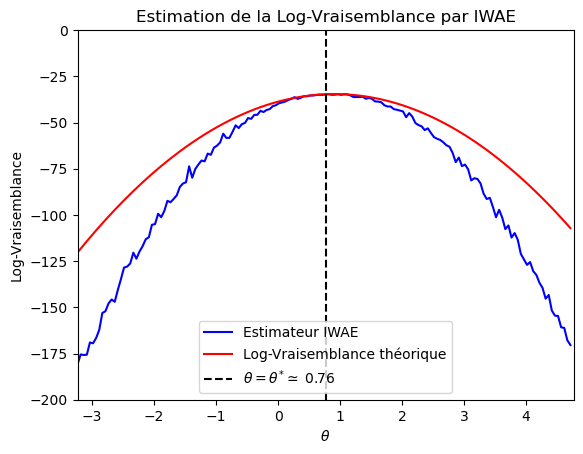

In [70]:
list_iwae_mu = visualisation_IWAE(A_true, b_true, X_data, K_iwae, N)

plt.clf()
plt.plot(mu_list, list_iwae_mu, color='blue', label='Estimateur IWAE')
plt.plot(mu_list, list_log_likelihood_mu, color='red', label='Log-Vraisemblance théorique')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel('Log-Vraisemblance')
plt.ylim(-200,0)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation de la Log-Vraisemblance par IWAE')
plt.show()

### E - Estimateur SUMO

#### E.1 - Création de l'estimateur

In [71]:
def SUMO_estimator(A, b, x, mu, N_sim):
    list_sumo = []
    for i in range(N_sim):
        K = np.random.geometric(r)
        Z_data = generate_z(K, A, b, x)
        q = q_phi(Z_data, A, b, x)
        p = p_joint(Z_data, K, x, mu)
        log_w = np.log(p) - np.log(q)
        I0 = np.mean(log_w)
        SUMO = I0
        for k in range(K+1):
            l2 = logsumexp(log_w[:2**(k+1)]) - np.log(len(log_w[:2**(k+1)]))
            l1 = logsumexp(log_w[:2**k]) - np.log(len(log_w[:2**k]))
            SUMO += (l2-l1)/((1-r)**max(k-1,0))
        list_sumo.append(SUMO)
    return np.mean(list_sumo)

#### E.2 Visualisation SUMO

In [72]:
def visualisation_SUMO(A, b, x, N_sim):
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    list_sumo_mu = []
    for mu in mu_list:
        list_sumo_mu_10 = []
        for i in range(10):
            sumo_estimator = SUMO_estimator(A_perturbed, b_perturbed, x, mu, N_sim)
            list_sumo_mu_10.append(sumo_estimator)
        mean_sumo = np.mean(list_sumo_mu_10)
        list_sumo_mu.append(mean_sumo)
    return list_sumo_mu

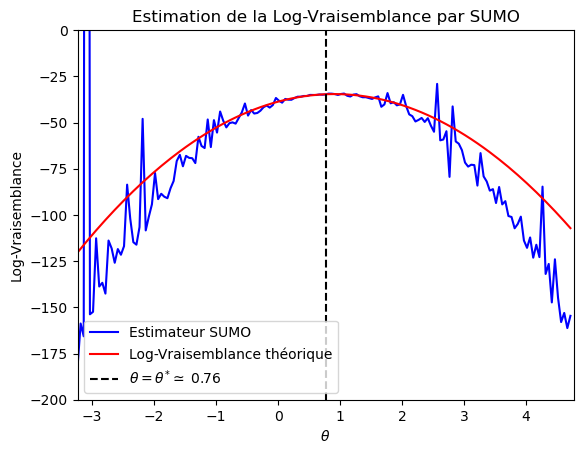

In [73]:
list_sumo_mu = visualisation_SUMO(A_true, b_true, X_data, N)

plt.clf()
plt.plot(mu_list, list_sumo_mu, color='blue', label='Estimateur SUMO')
plt.plot(mu_list, list_log_likelihood_mu, color='red', label='Log-Vraisemblance théorique')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel('Log-Vraisemblance')
plt.ylim(-200,0)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation de la Log-Vraisemblance par SUMO')
plt.show()

### F. Visualisation de tous les estimateurs

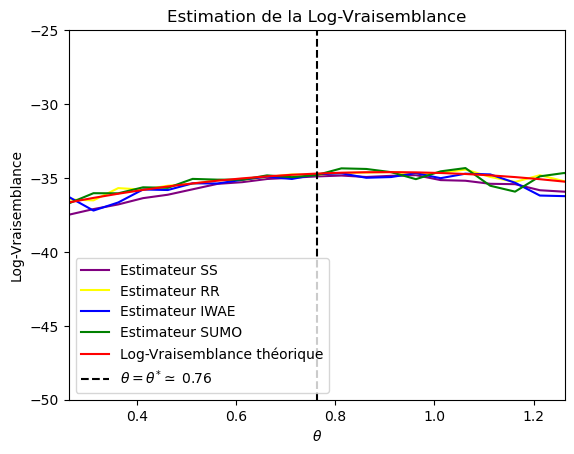

In [74]:
plt.clf()
plt.plot(mu_list, list_ss_mu, color='purple', label='Estimateur SS')
plt.plot(mu_list, list_rr_mu, color='yellow', label='Estimateur RR')
plt.plot(mu_list, list_iwae_mu, color='blue', label='Estimateur IWAE')
plt.plot(mu_list, list_sumo_mu, color='green', label='Estimateur SUMO')
plt.plot(mu_list, list_log_likelihood_mu, color='red', label='Log-Vraisemblance théorique')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel('Log-Vraisemblance')
plt.ylim(-50,-25)
plt.xlim(-0.5+theta, theta+0.5)
plt.legend(loc='best')
plt.title('Estimation de la Log-Vraisemblance')
plt.show()

## Partie 3 : Estimation du gradient  
Dans cette partie nous allons estimer $\nabla_{\theta} \ l(\theta) = \nabla_{\theta}\log \ p_{\theta}(x)$  
  
  l'identité de Fisher nous donne : $\nabla_{\theta}  l(\theta) =\int_{}^{}p_{\theta}(x|z)\nabla_{\theta} log \ p_{\theta}(x,z)dz$ ,ainsi estimer $\nabla_{\theta} \ l(\theta)$ revient à estimer $\pi[\psi]$ (Voir définition en 2.1 de l'article) avec $\psi(z) := \nabla_{\theta} log \ p_{\theta}(x,z)$  
    
  Pour IWAE nous utiliserons l'estimateur biaisé SNIS : $\widehat{\pi}^{(k)}[\psi] = \nabla _{\theta}\widehat{l}^{(k)}(\theta) = \sum_{i=1}^{k}\overline{w_{i}} \ \nabla_{\theta} log \ p_{\theta}(x,z_{i})$  
  Pour RR et SS nous utiliserons la méthode MLMC

### A - Gradient théorique $\nabla_{\theta} \ l(\theta)$

In [75]:
list_gradient_log_likelihood_mu = np.gradient(list_log_likelihood_mu)

### B - Estimateur SS du gradient

In [76]:
list_pi_ss_mu = np.gradient(list_ss_mu)

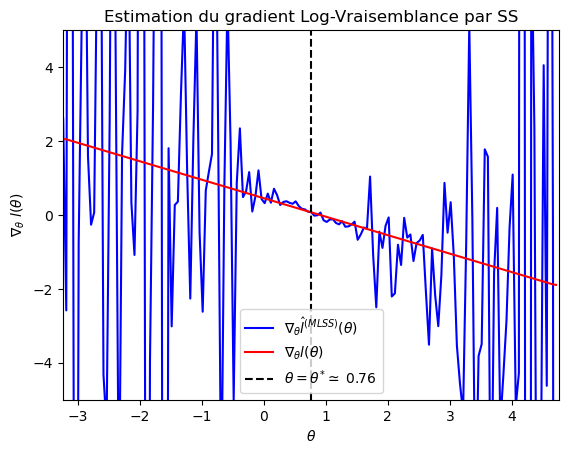

In [77]:
plt.clf()
plt.plot(mu_list, list_pi_ss_mu, color='blue', label=r'$\nabla _{\theta}\widehat{l}^{(MLSS)}(\theta)$')
plt.plot(mu_list, list_gradient_log_likelihood_mu, color='red', label=r'$\nabla_{\theta}l(\theta)$')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\nabla_{\theta} \ l(\theta)$')
plt.ylim(-5,5)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation du gradient Log-Vraisemblance par SS')
plt.show()

### C - Estimateur RR du gradient

In [78]:
list_pi_rr_mu = np.gradient(list_rr_mu)

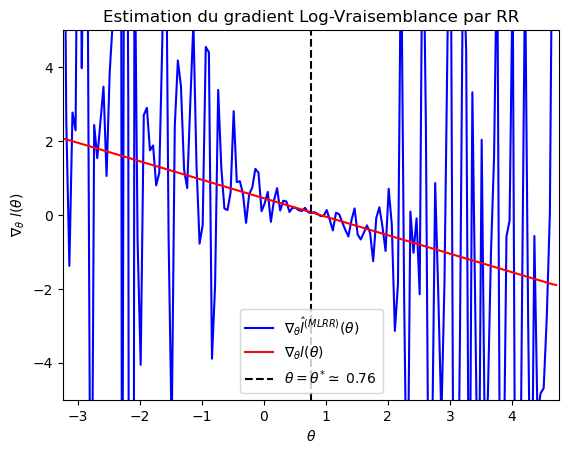

In [79]:
plt.clf()
plt.plot(mu_list, list_pi_rr_mu, color='blue', label=r'$\nabla _{\theta}\widehat{l}^{(MLRR)}(\theta)$')
plt.plot(mu_list, list_gradient_log_likelihood_mu, color='red', label=r'$\nabla_{\theta}l(\theta)$')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\nabla_{\theta} \ l(\theta)$')
plt.ylim(-5,5)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation du gradient Log-Vraisemblance par RR')
plt.show()

### D - Estimateur IWAE du gradient

In [80]:
list_pi_iwae_mu = np.gradient(list_iwae_mu)

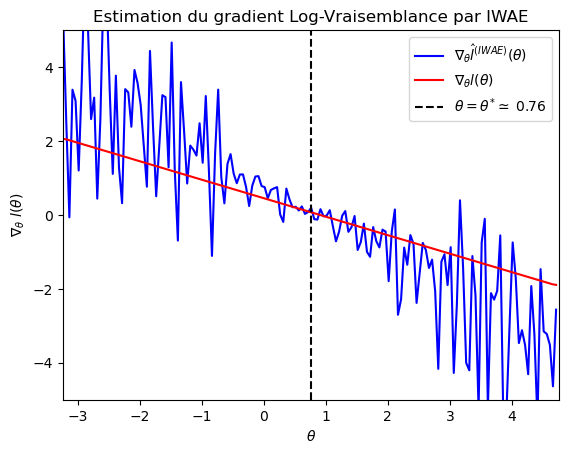

In [81]:
plt.clf()
plt.plot(mu_list, list_pi_iwae_mu, color='blue', label=r'$\nabla _{\theta}\widehat{l}^{(IWAE)}(\theta)$')
plt.plot(mu_list, list_gradient_log_likelihood_mu, color='red', label=r'$\nabla_{\theta}l(\theta)$')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\nabla_{\theta} \ l(\theta)$')
plt.ylim(-5,5)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation du gradient Log-Vraisemblance par IWAE')
plt.show()

### E - Estimateur SUMO du gradient

In [82]:
list_pi_sumo_mu = np.gradient(list_sumo_mu)

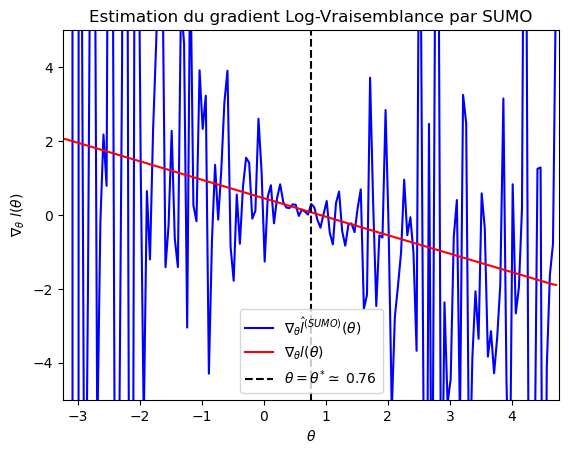

In [83]:
plt.clf()
plt.plot(mu_list, list_pi_sumo_mu, color='blue', label=r'$\nabla _{\theta}\widehat{l}^{(SUMO)}(\theta)$')
plt.plot(mu_list, list_gradient_log_likelihood_mu, color='red', label=r'$\nabla_{\theta}l(\theta)$')
plt.axvline(x=theta, color='black', linestyle='dashed', label=r'$\theta = \theta^{*} \simeq$ ' + str(round(theta,2)))
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\nabla_{\theta} \ l(\theta)$')
plt.ylim(-5,5)
plt.xlim(start+theta, end+theta)
plt.legend(loc='best')
plt.title('Estimation du gradient Log-Vraisemblance par SUMO')
plt.show()

## Partie 4 : Anlyse de la variance et du biais  
Dans cette partie nous allons reproduire la figure 2 de l'article

### A - Biais au carré de la Log-Vraisemblance

In [84]:
log_likelihood_theta = log_likelihood(X_data, theta)

In [85]:
def bias_log_likelihood(A, b ,x , debut_sim, fin_sim , pas_sim):
    n_sim_list = np.arange(debut_sim, fin_sim, pas_sim)
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    bias_ss_n_sim, bias_rr_n_sim, bias_iwae_n_sim, bias_sumo_n_sim = [], [], [], []
    for n_sim in n_sim_list:
        bias_ss_n_sim.append((SS_estimator(A_perturbed, b_perturbed, x, theta, n_sim)-log_likelihood_theta)**2)
        bias_rr_n_sim.append((RR_estimator(A_perturbed, b_perturbed, x, theta, n_sim)-log_likelihood_theta)**2)
        bias_iwae_n_sim.append((IWAE_estimator(A_perturbed, b_perturbed, x, theta, K_iwae, n_sim)-log_likelihood_theta)**2)
        bias_sumo_n_sim.append((SUMO_estimator(A_perturbed, b_perturbed, x, theta, n_sim)-log_likelihood_theta)**2)
    return n_sim_list, bias_ss_n_sim, bias_rr_n_sim, bias_iwae_n_sim, bias_sumo_n_sim

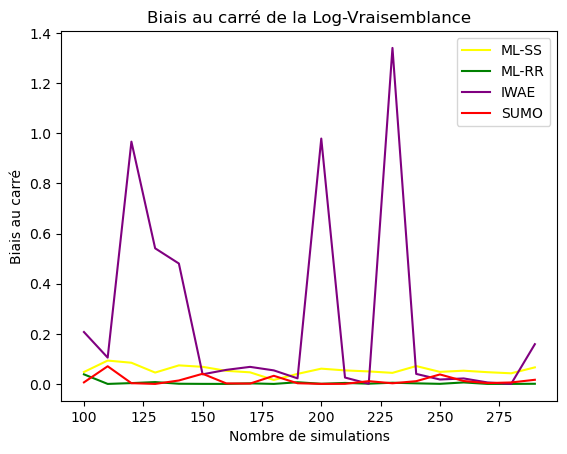

In [86]:
n_sim_list, bias_ss_n_sim, bias_rr_n_sim, bias_iwae_n_sim, bias_sumo_n_sim = bias_log_likelihood(A_true, b_true , X_data , 100, 300 , 10)

plt.clf()
plt.plot(n_sim_list, bias_ss_n_sim, color='yellow', label='ML-SS')
plt.plot(n_sim_list, bias_rr_n_sim, color='green', label='ML-RR')
plt.plot(n_sim_list, bias_iwae_n_sim, color='purple', label='IWAE')
plt.plot(n_sim_list, bias_sumo_n_sim, color='red', label='SUMO')
plt.xlabel('Nombre de simulations')
plt.ylabel('Biais au carré')
plt.legend(loc='best')
plt.title('Biais au carré de la Log-Vraisemblance')
plt.show()

### B - Biais au carré du gradient

In [87]:
log_likelihood_theta_gradient = 10*(X_data.mean()-theta)

In [88]:
def bias_gradient_log_likelihood(A, b ,x):
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    bias_gradient_ss_list, bias_gradient_rr_list, bias_gradient_iwae_list, bias_gradient_sumo_list = [], [], [], []
    for n_sim in n_sim_list:
        print(n_sim)
        ss_left = SS_estimator(A_perturbed, b_perturbed, x, theta-0.05, n_sim)
        ss_right = SS_estimator(A_perturbed, b_perturbed, x, theta+0.05, n_sim)
        gradient_ss = (ss_right - ss_left)/0.1
        bias_gradient_ss_list.append((gradient_ss-log_likelihood_theta_gradient)**2)
        rr_left = RR_estimator(A_perturbed, b_perturbed, x, theta-0.05, n_sim)
        rr_right = RR_estimator(A_perturbed, b_perturbed, x, theta+0.05, n_sim)
        gradient_rr = (rr_right - rr_left)/0.1
        bias_gradient_rr_list.append((gradient_rr-log_likelihood_theta_gradient)**2)
        iwae_left = IWAE_estimator(A_perturbed, b_perturbed, x, theta-0.05, K_iwae, n_sim)
        iwae_right = IWAE_estimator(A_perturbed, b_perturbed, x, theta+0.05, K_iwae, n_sim)
        gradient_iwae = (iwae_right - iwae_left)/0.1
        bias_gradient_iwae_list.append((gradient_iwae-log_likelihood_theta_gradient)**2)
        sumo_left = SUMO_estimator(A_perturbed, b_perturbed, x, theta-0.05, n_sim)
        sumo_right = SUMO_estimator(A_perturbed, b_perturbed, x, theta+0.05, n_sim)
        gradient_sumo = (sumo_right - sumo_left)/0.1
        bias_gradient_sumo_list.append((gradient_sumo-log_likelihood_theta_gradient)**2)
    return bias_gradient_ss_list, bias_gradient_rr_list, bias_gradient_iwae_list, bias_gradient_sumo_list

100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


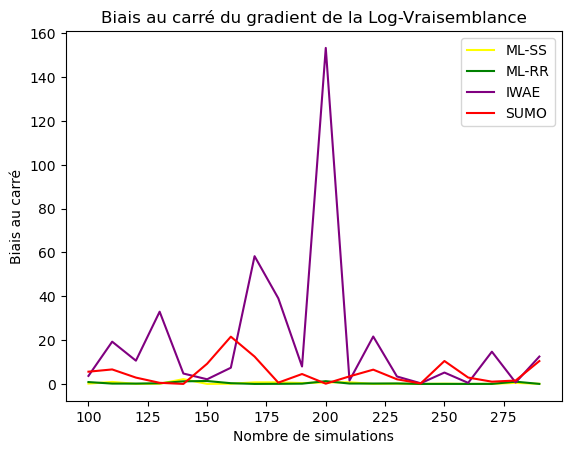

In [89]:
bias_gradient_ss_list, bias_gradient_rr_list, bias_gradient_iwae_list, bias_gradient_sumo_list = bias_gradient_log_likelihood(A_true, b_true , X_data)

plt.clf()
plt.plot(n_sim_list, bias_gradient_ss_list, color='yellow', label='ML-SS')
plt.plot(n_sim_list, bias_gradient_rr_list, color='green', label='ML-RR')
plt.plot(n_sim_list, bias_gradient_iwae_list, color='purple', label='IWAE')
plt.plot(n_sim_list, bias_gradient_sumo_list, color='red', label='SUMO')
plt.xlabel('Nombre de simulations')
plt.ylabel('Biais au carré')
plt.legend(loc='best')
plt.title('Biais au carré du gradient de la Log-Vraisemblance')
plt.show()

### C - Variance de la Log-Vraisemblance

In [90]:
def var_log_likelihood(A, b, x):
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    var_ss, var_rr, var_iwae, var_sumo = [], [], [], []
    for n_sim in n_sim_list:
        var_ss_n_sim, var_rr_n_sim, var_iwae_n_sim, var_sumo_n_sim = [], [], [], []
        for i in range(5):
            var_ss_n_sim.append(SS_estimator(A_perturbed, b_perturbed, x, theta, n_sim))
            var_rr_n_sim.append(RR_estimator(A_perturbed, b_perturbed, x, theta, n_sim))
            var_iwae_n_sim.append(IWAE_estimator(A_perturbed, b_perturbed, x, theta, K_iwae, n_sim))
            var_sumo_n_sim.append(SUMO_estimator(A_perturbed, b_perturbed, x, theta, n_sim))
        var_ss.append(np.var(var_ss_n_sim))
        var_rr.append(np.var(var_rr_n_sim))
        var_iwae.append(np.var(var_iwae_n_sim))
        var_sumo.append(np.var(var_sumo_n_sim))
    return var_ss, var_rr, var_iwae, var_sumo

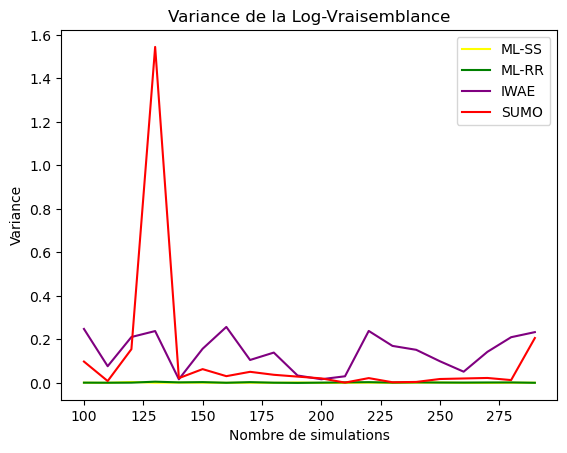

In [91]:
var_ss, var_rr, var_iwae, var_sumo = var_log_likelihood(A_true, b_true , X_data)

plt.clf()
plt.plot(n_sim_list, var_ss, color='yellow', label='ML-SS')
plt.plot(n_sim_list, var_rr, color='green', label='ML-RR')
plt.plot(n_sim_list, var_iwae, color='purple', label='IWAE')
plt.plot(n_sim_list, var_sumo, color='red', label='SUMO')
plt.xlabel('Nombre de simulations')
plt.ylabel('Variance')
plt.legend(loc='best')
plt.title('Variance de la Log-Vraisemblance')
plt.show()

### D - Variance du gradient

In [92]:
def var_gradient_log_likelihood(A, b, x):
    A_perturbed, b_perturbed = parameter_perturbation(A, b)
    var_grad_ss, var_grad_rr, var_grad_iwae, var_grad_sumo = [], [], [], []
    for n_sim in n_sim_list:
        var_ss_n_sim, var_rr_n_sim, var_iwae_n_sim, var_sumo_n_sim = [], [], [], []
        for i in range(5):
            ss_left = SS_estimator(A_perturbed, b_perturbed, x, theta-0.05, n_sim)
            ss_right = SS_estimator(A_perturbed, b_perturbed, x, theta+0.05, n_sim)
            gradient_ss = (ss_right - ss_left)/0.1
            var_ss_n_sim.append(gradient_ss)
            rr_left = RR_estimator(A_perturbed, b_perturbed, x, theta-0.05, n_sim)
            rr_right = RR_estimator(A_perturbed, b_perturbed, x, theta+0.05, n_sim)
            gradient_rr = (rr_right - rr_left)/0.1
            var_rr_n_sim.append(gradient_rr)
            iwae_left = IWAE_estimator(A_perturbed, b_perturbed, x, theta-0.05, K_iwae, n_sim)
            iwae_right = IWAE_estimator(A_perturbed, b_perturbed, x, theta+0.05, K_iwae, n_sim)
            gradient_iwae = (iwae_right - iwae_left)/0.1
            var_iwae_n_sim.append(gradient_iwae)
            sumo_left = SUMO_estimator(A_perturbed, b_perturbed, x, theta-0.05, n_sim)
            sumo_right = SUMO_estimator(A_perturbed, b_perturbed, x, theta+0.05, n_sim)
            gradient_sumo = (sumo_right - sumo_left)/0.1
            var_sumo_n_sim.append(gradient_sumo)
        var_grad_ss.append(np.var(var_ss_n_sim))
        var_grad_rr.append(np.var(var_rr_n_sim))
        var_grad_iwae.append(np.var(var_iwae_n_sim))
        var_grad_sumo.append(np.var(var_sumo_n_sim))
    return var_grad_ss, var_grad_rr, var_grad_iwae, var_grad_sumo

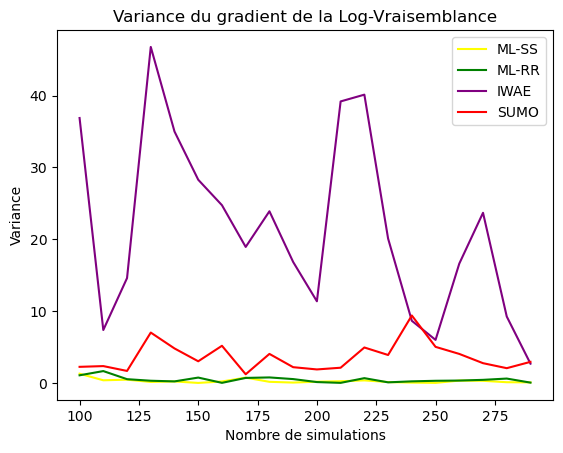

In [102]:
var_grad_ss, var_grad_rr, var_grad_iwae, var_grad_sumo = var_gradient_log_likelihood(A_true, b_true , X_data)

plt.clf()
plt.plot(n_sim_list, var_grad_ss, color='yellow', label='ML-SS')
plt.plot(n_sim_list, var_grad_rr, color='green', label='ML-RR')
plt.plot(n_sim_list, var_grad_iwae, color='purple', label='IWAE')
plt.plot(n_sim_list, var_grad_sumo, color='red', label='SUMO')
plt.xlabel('Nombre de simulations')
plt.ylabel('Variance')
plt.legend(loc='best')
plt.title('Variance du gradient de la Log-Vraisemblance')
plt.show()

## Partie 5 : Descente de gradient stochastique

In [94]:
def nearest_index(array, x):
    diff = np.abs(array - x)
    nearest_index = np.argmin(diff)
    return nearest_index

In [95]:
def sgd(theta_array, y_grad, learning_rate, num_iterations, y_name):
  estim = 0
  for i in range(num_iterations):
    proche = nearest_index(theta_array, estim)
    gradi = y_grad[proche]
    estim += learning_rate*gradi
  print("Theta estimé par " + y_name + ": " + str('{:.2f}'.format((estim))))

In [96]:
true_Y = [10*(X_data.mean()-mu) for mu in mu_list]

In [101]:

print("Theta = " + str('{:.2f}'.format((theta))))
sgd(mu_list,list_pi_ss_mu,0.001,1000,"SS"),sgd(mu_list,list_pi_rr_mu,0.001,1000,"RR"),sgd(mu_list,list_pi_iwae_mu,0.001,1000,"SUMO"),sgd(mu_list,list_pi_sumo_mu,0.001,1000,"IWAE")

Theta = 0.76
Theta estimé par SS: 0.39
Theta estimé par RR: 0.09
Theta estimé par SUMO: 0.25
Theta estimé par IWAE: -0.01


(None, None, None, None)